[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mateus_gheorghe/neural_prophet/blob/master/tutorials/feature-use/global_modeling.ipynb)

# Global Model
When fitting a single forecasting model with shared weights using a dataset composed of many time series, we can achieve what is known as a **global model**. It is specially useful in cases in which (i) a single time series may not reflect the entire time series dynamics; or when (ii) demanding better generalization and model size saving. In this notebook, we will build a global model using data from the hourly load of the ERCOT region.

First, we load the data:

In [42]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes

import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet import set_random_seed
set_random_seed(8)
set_log_level("ERROR","INFO")

In [3]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
df_ercot = pd.read_csv(data_location + "energy/ERCOT_load.csv")
df_ercot.head()

,ds,COAST,EAST,FAR_WEST,NORTH,NORTH_C,SOUTHERN,SOUTH_C,WEST,y
0,2004-01-01 01:00:00,7225.09,877.79,1044.89,745.79,7124.21,1660.45,3639.12,654.61,22971.94
1,2004-01-01 02:00:00,6994.25,850.75,1032.04,721.34,6854.58,1603.52,3495.16,639.88,22191.52
2,2004-01-01 03:00:00,6717.42,831.63,1021.10,699.70,6639.48,1527.99,3322.70,623.42,21383.44
3,2004-01-01 04:00:00,6554.27,823.56,1015.41,691.84,6492.39,1473.89,3201.72,613.49,20866.56
4,2004-01-01 05:00:00,6511.19,823.38,1009.74,686.76,6452.26,1462.76,3163.74,613.32,20723.15


Here we can see each of the eight regions present at the ERCOT dataset.

In [4]:
regions = list(df_ercot)[1:-1]
regions

['COAST',
 'EAST',
 'FAR_WEST',
 'NORTH',
 'NORTH_C',
 'SOUTHERN',
 'SOUTH_C',
 'WEST']

We are going to select data from a three years interval in our example (from 2004 to 2007).

In [5]:
df_list=list()
for cols in regions:
    aux=df_ercot[['ds',cols]].copy()
    aux=aux.iloc[:26301,:].copy()
    aux=aux.rename(columns={cols:'y'})
    df_list.append(aux)

In [6]:
df_list[0].head()

,ds,y
0,2004-01-01 01:00:00,7225.09
1,2004-01-01 02:00:00,6994.25
2,2004-01-01 03:00:00,6717.42
3,2004-01-01 04:00:00,6554.27
4,2004-01-01 05:00:00,6511.19


In [7]:
df_list[0].tail()

,ds,y
26296,2006-12-31 20:00:00,8729.56
26297,2006-12-31 21:00:00,8616.09
26298,2006-12-31 22:00:00,8396.09
26299,2006-12-31 23:00:00,8211.95
26300,2007-01-01 00:00:00,8059.74


We are going to define a model which predicts the next hour based on the last 24 hours. At first, we are going to split our data into train and test (with a 33% test proportion - 2 years train and 1 year test).

In [8]:
m=NeuralProphet(n_lags=24)
df_train_list,df_test_list=m.split_df(df_list,freq='H',valid_p=0.33)

Next, we are going to manually normalize each of the regions independently.

In [9]:
#Normalize each region separately:
df_train_list_n=list()
df_test_list_n=list()
i=1
for df_train,df_test in zip(df_train_list,df_test_list): 
    print(i)
    df_train_n=df_train.copy(deep=True)
    df_test_n=df_test.copy(deep=True)
    norm_parameter=df_train_n['y'].abs().max()
    df_train_n['y']=df_train_n['y']/norm_parameter
    df_test_n['y']=df_test_n['y']/norm_parameter
    df_train_list_n.append(df_train_n)
    df_test_list_n.append(df_test_n)   
    i=i+1

1
2
3
4
5
6
7
8


Quick comparing single df before and after normalization.

In [10]:
print(df_train_list[0].head())
print(df_train_list_n[0].head())
print(df_test_list[0].head())
print(df_test_list_n[0].head())

                   ds        y
0 2004-01-01 01:00:00  7225.09
1 2004-01-01 02:00:00  6994.25
2 2004-01-01 03:00:00  6717.42
3 2004-01-01 04:00:00  6554.27
4 2004-01-01 05:00:00  6511.19
                   ds         y
0 2004-01-01 01:00:00  0.434148
1 2004-01-01 02:00:00  0.420277
2 2004-01-01 03:00:00  0.403643
3 2004-01-01 04:00:00  0.393839
4 2004-01-01 05:00:00  0.391251
                   ds        y
0 2006-01-04 08:00:00  8605.50
1 2006-01-04 09:00:00  8552.17
2 2006-01-04 10:00:00  8713.80
3 2006-01-04 11:00:00  8947.05
4 2006-01-04 12:00:00  9155.37
                   ds         y
0 2006-01-04 08:00:00  0.517096
1 2006-01-04 09:00:00  0.513891
2 2006-01-04 10:00:00  0.523603
3 2006-01-04 11:00:00  0.537619
4 2006-01-04 12:00:00  0.550137


Now we fit a model based on all of the normalized regions. Notice that the training procedure takes about 4 to 6 minutes since we are considering two years hourly data from 6 different regions.

In [11]:
metrics = m.fit(df_train_list_n, freq='H')
metrics.tail()

  0%|          | 0/357 [00:00<?, ?it/s]

  0%|          | 0/357 [00:00<?, ?it/s]

  0%|          | 0/357 [00:00<?, ?it/s]

,SmoothL1Loss,MAE,RMSE,RegLoss
48,0.000181,0.007777,0.010458,0.0
49,0.000177,0.007639,0.010325,0.0
50,0.000174,0.007559,0.010238,0.0
51,0.000172,0.007486,0.010169,0.0
52,0.000170,0.007448,0.010129,0.0


## Test single region

One can test a single region in the fitted model (i.e. North).

In [12]:
region=3
print(f'Testing single region: {regions[region]}')
test_metrics=m.test(df_test_list_n[region])
test_metrics

Testing single region: NORTH


,SmoothL1Loss,MAE,RMSE
0,0.00152,0.02728,0.02906


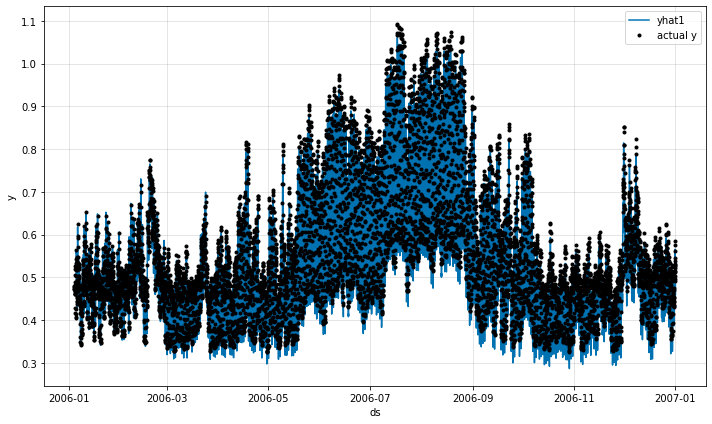

In [13]:
future = m.make_future_dataframe(df_test_list_n[region], n_historic_predictions=True)
forecast = m.predict(future)
fig = m.plot(forecast)

## Test multiple regions

Or even test many time series at once (i.e. East, Far West, South).

In [39]:
region=[1,2,5]
print(f'Testing regions: {[regions[i] for i in region]}')
df_test_specific_regions=[df_test_list_n[i] for i in region]
test_metrics=m.test(df_test_specific_regions)
test_metrics

Testing regions: ['EAST', 'FAR_WEST', 'SOUTHERN']


,SmoothL1Loss,MAE,RMSE
0,0.001627,0.027938,0.030357


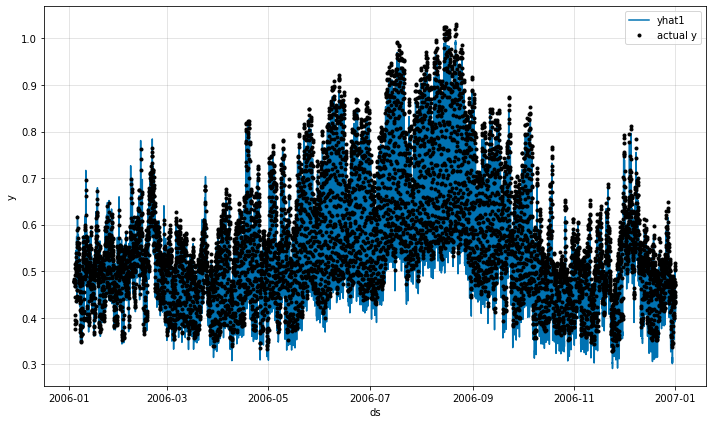

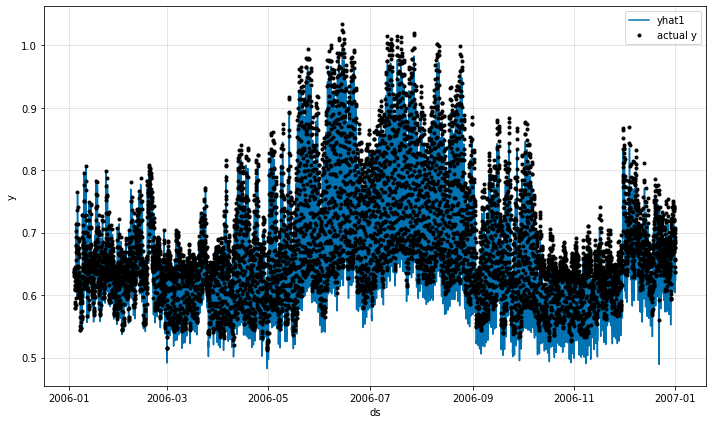

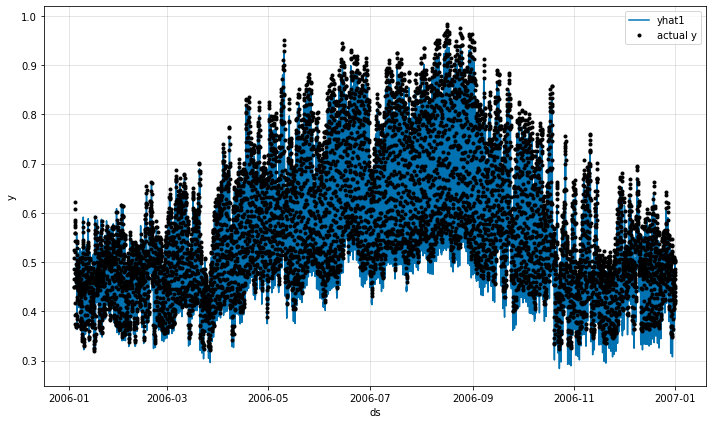

In [40]:
future = m.make_future_dataframe(df_test_specific_regions, n_historic_predictions=True)
forecast = m.predict(future)
for frst in forecast:
    fig = m.plot(frst)

Finally, we can even plot the parameters of the shared weight trained model.

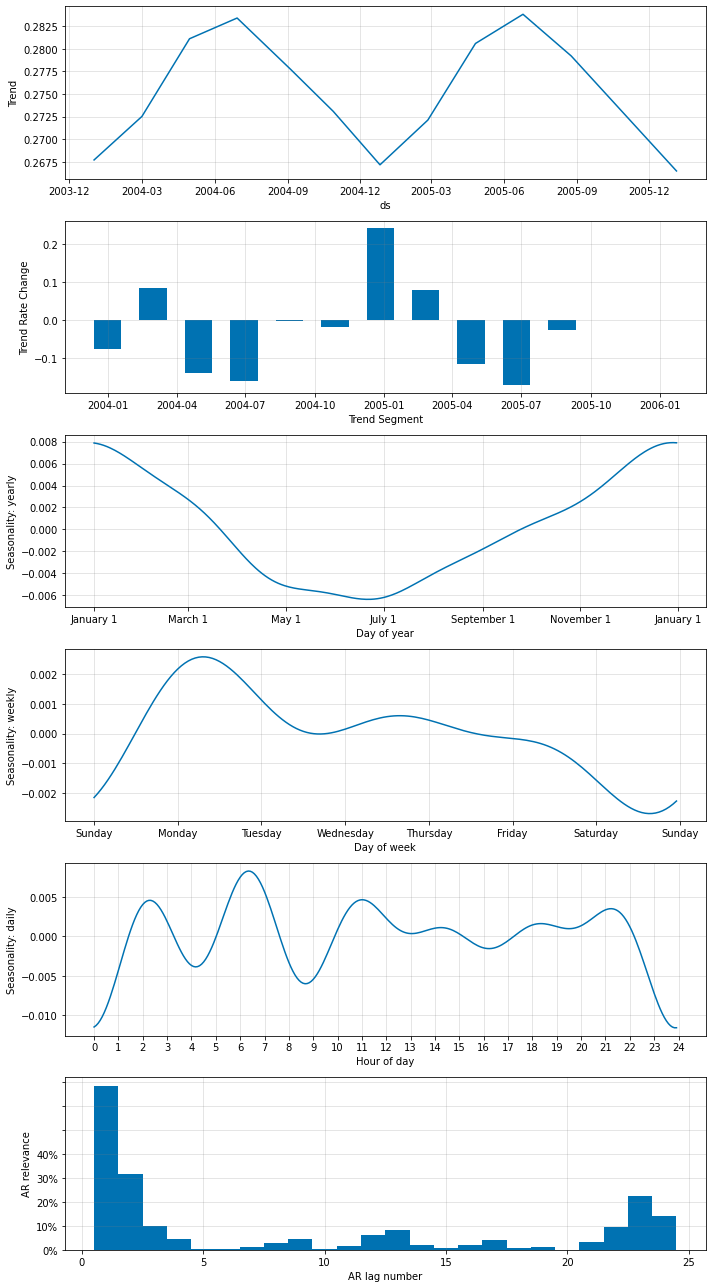

In [41]:
fig_param = m.plot_parameters()